# Regressão de Séries temporais utilizando redes recorrentes

Uma série temporal pode ser definida como uma coleção de observações feitas sequencialmente ao longo do tempo. Em outras palavras, trata-se de uma informação dinâmica onde padrões que ocorreram no passado podem influenciar no futuro.

Abaixo, apresento uma série temporal qualquer, onde o eixo das abscissas é o tempo e o das ordenadas é uma grandeza medida:

![st](https://user-images.githubusercontent.com/32513366/72760899-03fb2280-3bb9-11ea-9c55-40733335d183.gif)

Nesta prática, o problema a ser analisado será:

**Predição de valores futuros de uma série temporal a partir de valores passados**

Para isso, será usado uma Rede Recorrente ou *Recurent Neural Networks* (RNN). Este modelo é um tipo de algoritmo de *Deep Learning*, que apresenta como maior característica o aprendizado ao longo do tempo. Em outras palavras, ele consegue aprender relações dinâmicas.

De forma geral, neste notebook você irá aprender:

- Como fazer pré-processamento para treinamento de modelos recorrentes
- Terminologias de redes neurais: *batch*, *epoch* e *iterations*
- Teoria geral sobre RNN
- Teoria e aplicação de LSTM(*Long-Short Term Memory*) e GRU(*Gated Recurrent Unit*), ambas variações de RNN
- O que é Transferência de aprendizado (*Transfer Learning*) e como aplica-lo

Vale ressaltar que este material foi baseado em diversos conteúdos encontrados de forma gratuita na internet, em inglês, para mais informações veja a aba **Referências**.

# Módulos

In [1]:
# Biblioteca básica do python
import numpy as np
import pandas as pd
# Para etapa de pré-processamento
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Para o desenvolvimento dos modelos de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
# Para fazer alguns gráficos caso necessário
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Definir semente para reprodutibilidade
np.random.seed(1206)

# Parte 1: Importando os dados

Para este estudo, serão utilizados duas séries temporais distintas
- **Histórico de ações da Apple Inc.**
- **Produção de leite mensal**

Dado ao foco deste trabalho ser principalmente o aprendizado da teoria e aplicação de RNN, as unidades não irão importar tanto visto que os bancos de dados são relativamente pequenos.

In [3]:
# Importando banco de dados
data_apple = pd.read_csv('./dados/apple_prices.csv', names=['preco'], header=None)
data_leite = pd.read_csv('./dados/monthly-milk-production-pounds.csv')

# Corrigindo alguns detalhes dos bancos de dados
data_leite = data_leite[0:168]
data_leite.columns = ['mes', 'producao']

In [4]:
# Tornando as colunas em arrays de dimensão (N,1)
producao = data_leite['producao'].values.reshape((-1,1))
preco = data_apple['preco'].values.reshape((-1,1))

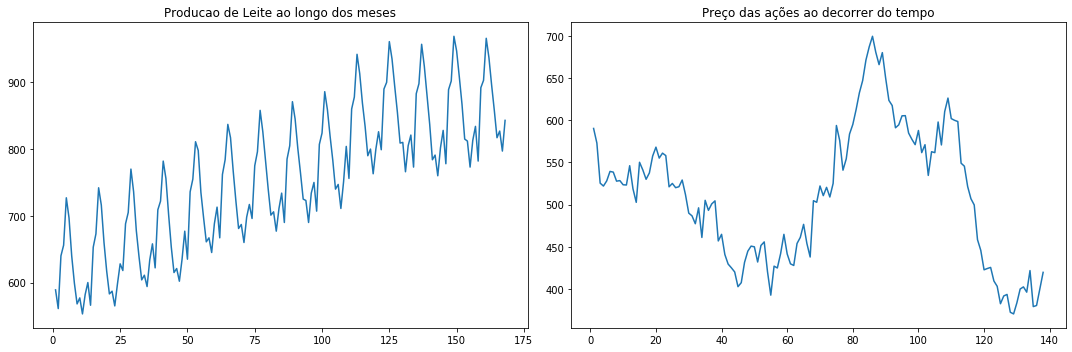

In [5]:
# Fazer os gráficos de ambas as séries
## Declarar eixos e a figura
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
## Plot producao de leite
ax1.set_title('Producao de Leite ao longo dos meses')
ax1.plot(list(range(1,len(producao)+1)),list(producao.reshape(-1)));
## Plot preços da Apple
ax2.set_title('Preço das ações ao decorrer do tempo')
ax2.plot(list(range(1,len(preco)+1)),list(preco.reshape(-1)));
## Comando para melhorar a disposição de cada plot
plt.tight_layout()

Note que ambas as séries apresentam comportamentos distintos. 

O **objetivo** para este notebook será: prever os **20% finais** de cada série utilizando RNN/*Transfer Learning*.

## Parte 2: Pré-processamento dos dados

O pré-processamento dos dados é uma parte essencial para qualquer criação de modelo, seja ele uma *Deep Learning* ou não. Essa etapa garante que ruídos desnecessários ou enganosos não sejam transmitidos considerados. Além disso, é aqui onde ocorre a divisão dos dados em dois conjuntos: treinamento e teste.

Para estas séries temporais, serão feitas as seguintes etapas:
- Hold-out split 80/20
- Padronização Z-Score
- Janelas temporais

### Hold-out split 80/20
Método que consiste na divisão do seu conjunto total de dados em dois: treinamento e teste. O primeiro conjunto é utilizado para treinar os parâmetros do seu modelo. Já o segundo é utilizado para avaliar a qualidade(métricas) do mesmo para informações inéditas.

Note que aqui eu apresento no nome *80/20*, isso implica que 80% dos seus dados serão para treinamento e 20% para teste. Vale ressaltar que existem outras formas de divisão como *70/30* ou *85/15* que seguem a mesma lógica. Sua escolha dependem do usuário e da quantidade de amostras.


In [6]:
# Porcentagem de divisão dos dados
split = 0.80

# Divisão para produção de leite
pSplit = int(split*len(producao))
producao_train = producao[:pSplit] 
producao_test = producao[pSplit:]

# Divisão para preços da Apple
aSplit = int(split*len(preco))
preco_train = preco[:aSplit]
preco_test = preco[aSplit:]

# Print
print('Producão -> Train: ',len(producao_train),' Test: ',len(producao_test))
print('Preço    -> Train: ',len(preco_train),' Test: ',len(preco_test))

Producão -> Train:  134  Test:  34
Preço    -> Train:  110  Test:  28


Um detalhe importante a ser mencionado é o fato de não pegar amostras aleatórias para compor treinamento/teste como é feito usualmente, necessário para não tornar o modelo enviesado, isso ocorre porque estamos lidando com séries temporais, ou seja, a ordem de cada valor é importante para garantir que o modelo adquira corretamente a dinâmica temporal.

**PS**: Caso trabalhe com dados não temporais, o recomendado é pegar amostras aleatórias.

## Padronização Z-score
A padronização Z-score consiste em aplicar para cada amostra a seguinte formula:
![zs](https://user-images.githubusercontent.com/32513366/72865384-6554eb80-3cb6-11ea-831d-6fcf5bfca761.png)

Onde
- *Mi* é a média daquele conjunto
- *Sigma* o desvio padrão daquele conjunto
- *X* o valor amostral
- *Z* o novo valor

Isso é utilizado para padronizar as escalas das variáveis para deixa-las em intervalos equivalentes. Agora nesse momento você deve se perguntar **Por qual razão devo aplicar se apenas temos uma variável em cada conjunto?**

Bom, quando treinamos um modelo neural com valores muito distintos, 10 e 100 por exemplo, é possível que grandes valores tornem a convergência do aprendizado mais lenta ou até mesmo a impeça! Além disso, como as redes fazem diversas somas e multiplicações, valores maiores tendem a pesar muito mais do que os valores menores, algo não desejável. Essa complicação é muito mais evidente em modelos de aprendizado de máquina como K-NN(*K Nearest Neighbours*) ou K Means que utilizam o cálculo de distâncias entre vetores para funcionar.

De qualquer forma, é considerado boa prática aplicar a padronização das variáveis continuas. 

In [7]:
# Producao de Leite
## Declare o objeto para o processo de padronizacao
sspl = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
producao_train = sspl.fit_transform(X = producao_train)

## Transforme o conjunto de test baseado nos parâmetros de train
producao_test = sspl.transform(X = producao_test)

In [8]:
# Preco da Apple
## Declare o objeto para processo de padronizacao
sspa = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
preco_train = sspa.fit_transform(X = preco_train)

## Transforme o conjunto de test baseado nos parâmetros de train
preco_test = sspa.transform(X = preco_test)

Note que apliquei (*fit*) e transformei (*transform*) primeira o conjunto de treino para então depois, utilizando os mesmo parâmetros de média e desvio padrão, transformar o conjunto de teste. Isso é feito para garantir que não ocorra vazamento de informações (*leakage*): momento em que ocorre vazamento de informação fora do conjunto de treinamento para criação do modelo.

Ou seja, caso fosse aplicássemos a padronização em todo o conjunto ocorreria o vazamento de informação do conjunto de teste, que colaboraria para o cálculo de média e desvio padrão.  


## Janelas temporais
Relembrando, uma série temporal se trata de uma sequência de informações que pode ser representada matematicamente da seguinte forma:

$$x_{0},x_{1},x_{2},...,x_{P}$$

Onde $x_{p}$ é o valor numérico daquela variável no período $p$ e $P$ é o tamanho total daquela série.

Para aplicar o modelo de RNN, o problema de predição temporal será tratado como um problema de regressão e para isso precisamos aplicar a ideia de **janela móvel** para construir conjuntos de entrada/saída. Abaixo apresento uma exemplificação do que foi dito: 

![timeseries_windowing_training](https://user-images.githubusercontent.com/32513366/72760895-02315f00-3bb9-11ea-8db9-37dfe8fc1532.gif)

Ao aplicar a janela móvel será necessário definir:
- Tamanho da janela de entrada: quantas amostras passadas serão usadas para prever a saída
- Passo: Qual o passo no tempo que será usado para criar as janelas

No exemplo acima, o tamanho da janela temporal é 5 e o passo utilizado 1. Sua saída pode ser demostrada abaixo:

$$\begin{array}{c|c}
\text{Entrada} & \text{Saida}\\
\hline \color{Red} {\langle x_{1},x_{2},x_{3},x_{4},x_{5}\rangle} & \color{Goldenrod}{ x_{6}} \\
\ \color{Red} {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & \color{Goldenrod} {x_{7} } \\
\color{Red}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{Red} { \langle x_{P-5},x_{P-4},x_{P-3},x_{P-2},x_{P-1} \rangle } & \color{Goldenrod} {x_{P}}
\end{array}$$

Vale ressaltar que considerando uma série de tamanho $P$ e uma janela de tamanho $T$ será gerado ao final $P-T$ pares de entrada/saída.

Diversos códigos podem ser criados de forma manual, porém a biblioteca ```Keras``` já possui uma função que faz isso de forma mais simples em apenas uma linha.

In [20]:
# Tamanho da janela temporal utilizada para prever o valor futuro
window_size = 3

# Tamanho do batch
n_batchs = 3

In [21]:
# Criação das séries para producao
producao_train_sequence = TimeseriesGenerator(data=producao_train,
                                              targets=producao_train,
                                              length=window_size,
                                              batch_size=n_batchs)
producao_test_sequence = TimeseriesGenerator(data=producao_test,
                                              targets=producao_test,
                                              length=window_size,
                                              batch_size=1)

In [22]:
# Criação das séries para preço
preco_train_sequence = TimeseriesGenerator(data=preco_train,
                                           targets=preco_train,
                                           length=window_size,
                                           batch_size=n_batchs)
preco_test_sequence = TimeseriesGenerator(data=preco_test,
                                          targets=preco_test,
                                          length=window_size,
                                          batch_size=1)

Note que é necessário definir ```batch_size```, referente ao termo *batch size*. Ele, junto com *epoch* e *iterations* são bem recorrentes nessa área e valem ser mencionados aqui:
- **batch size**: quantidade de amostras de treinamento usadas para uma ida/retorno.
- **epoch**: quantidade de vezes que seu modelo verá todas as amostras de treinamento no processo de ida e retorno.
- **iterations**: quantidade de ida/retorno, em outras palavras, quantas vezes serão atualizados os pesos da sua rede. Esse valor está intrínseco ao tamanho do **batch size**.

Considere o termo **ida/retorno** como a propagação de informação pela rede (ida) e o aprendizado dos parâmetros da rede a partir do erro avaliado (retorno).

Para tornar esses termos mais factíveis, vamos a um exemplo: considere um conjunto de treinamento de 1000 amostras. Posso definir meu *batch* com o tamanho de 10 amostras e 50 *epochs*. Então baseado nesse exemplo poderei afirmar:
- Cada *epoch* irá conter 100 *iterations*
- Será necessário 10 amostras (um *batch*) para os pesos da rede serão alterados de acordo ao erro avaliado (média dos erros de cada amostra).
- Uma amostra irá ser vista pelo modelo 50 vezes.

# Parte 2: Teoria geral de RNN

Considere uma célula recorrente equivalente a uma célula (neurônio) de uma rede neural normal. A maior diferença reside na retroalimentação da saída como entrada para um estado futuro. Para exemplificar, veja a imagem abaixo: 

![rnnLayer](https://user-images.githubusercontent.com/32513366/72867535-098e6080-3cbe-11ea-8163-6b533494e5fc.png)

A seta de retroalimentação é comumente chamada de $hidden state$. 

Em termos mais simples para o período $p$ no tempo, a entrada de uma célula RNN será composta por {$x_{t}, h_{t-1}$} onde $h_{t-1}$ é a saída para a entrada $x_{t-1}$. A visão interna dela pode ser vista abaixo:

![RNN_Core2](https://user-images.githubusercontent.com/32513366/72867934-427b0500-3cbf-11ea-8b5d-85eed84c8b5b.png)

Todavia este modelo de célula sofre do problema *Vanishing gradient* que é quando modelos neurais profundos não conseguem propagar as informações durante o *backpropagation* para as camadas mais próximas da entrada, impedindo assim o aprendizado. Diversas técnicas foram lançadas para resolver essa questão, mas não entrarei em detalhes aqui. 

O importante a ressaltar aqui é que dado este problema, a RNN sofre muitas vezes de uma memória curta sendo incapaz de lembrar de informações mais antigas. Para sanar essa dificuldade, outras arquiteturas de células foram propostas: LSTM e GRU.

Dando continuidade a criação prática dos modelos, inicialmente serão gerados dois modelos, cada um seguindo u

# Parte 3: Criando a Rede Recorrente LSTM

In [16]:
# Criando objeto do modelo
lstm_model = Sequential(name='LSTM_MODEL')

In [17]:
# Adicionar primeira camada
lstm_model.add(LSTM(units=100,activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
lstm_model.add(LSTM(units=100,activation='relu'))
# Adicionar camada de saida
lstm_model.add(Dense(units=1))

Model: "LSTM_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Descrição do modelo
lstm_model.summary()
# Compilar o modelo
lstm_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])
# Treinando o modelo
LSTM_history = lstm_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

# Parte 4: Criando a Rede Recorrente GRU para produção de Leite

In [20]:
# Criando objeto do modelo
gru_model = Sequential(name='GRU_MODEL')

In [21]:
# Adicionar primeira camada
gru_model.add(GRU(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
gru_model.add(GRU(units=100, activation='relu'))
# Adicionar camada de saida
gru_model.add(Dense(units=1))

# Descrição do modelo
gru_model.summary()

Model: "GRU_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 100)            30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compilar o modelo
gru_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])

In [23]:
# Treinando o modelo
GRU_history = gru_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

Epoch 1/15
44/44 - 2s - loss: 0.7055 - mse: 0.7079
Epoch 2/15
44/44 - 2s - loss: 0.4222 - mse: 0.4246
Epoch 3/15
44/44 - 2s - loss: 0.3480 - mse: 0.3497
Epoch 4/15
44/44 - 2s - loss: 0.2929 - mse: 0.2942
Epoch 5/15
44/44 - 2s - loss: 0.2430 - mse: 0.2440
Epoch 6/15
44/44 - 2s - loss: 0.2415 - mse: 0.2421
Epoch 7/15
44/44 - 2s - loss: 0.2154 - mse: 0.2160
Epoch 8/15
44/44 - 2s - loss: 0.2345 - mse: 0.2344
Epoch 9/15
44/44 - 2s - loss: 0.2133 - mse: 0.2139
Epoch 10/15
44/44 - 2s - loss: 0.2033 - mse: 0.2027
Epoch 11/15
44/44 - 2s - loss: 0.2354 - mse: 0.2360
Epoch 12/15
44/44 - 2s - loss: 0.2182 - mse: 0.2189
Epoch 13/15
44/44 - 2s - loss: 0.2046 - mse: 0.2050
Epoch 14/15
44/44 - 2s - loss: 0.1999 - mse: 0.1996
Epoch 15/15
44/44 - 2s - loss: 0.2245 - mse: 0.2252


# Parte 5: Comparando os resultados

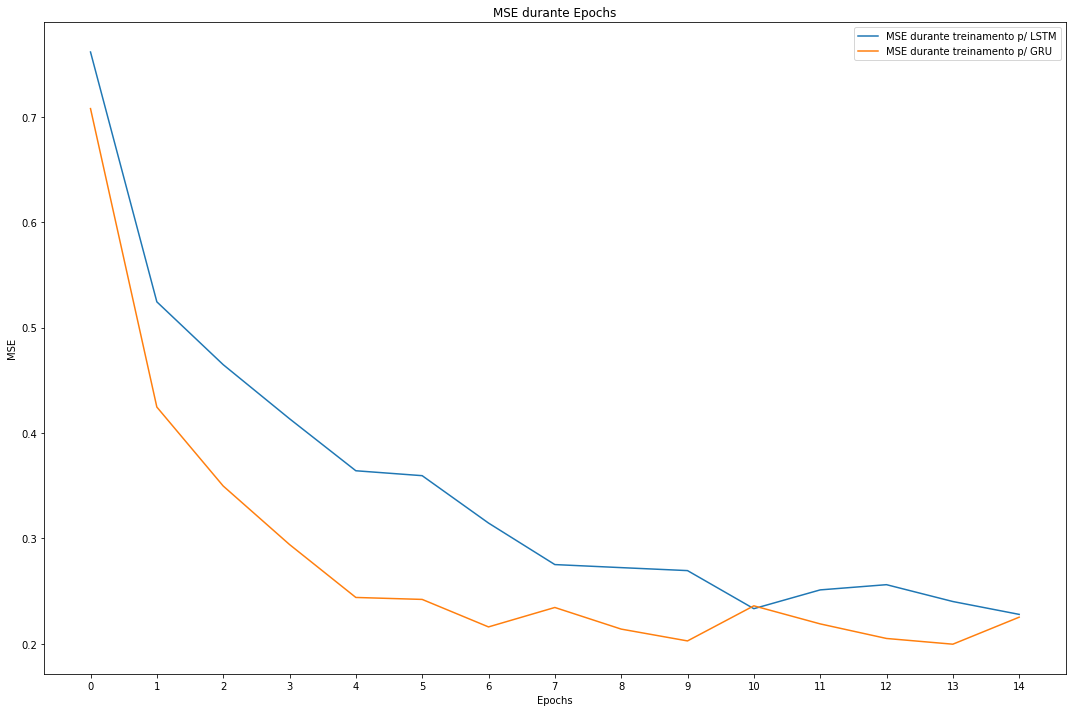

In [24]:
# Plot do treinamento
epochs_range = list(range(0,15))
# Plots
plt.figure(figsize=(15,10));
# Accuracy X Epochs
plt.plot(LSTM_history.history['mse'], label='MSE durante treinamento p/ LSTM')
plt.plot(GRU_history.history['mse'], label='MSE durante treinamento p/ GRU')
plt.title('MSE durante Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.xticks(epochs_range)
plt.legend(loc='upper right')

# Default to improve spaces between the plots
plt.tight_layout()

In [25]:
# Prever valores futuros(validação) com LSTM
LSTM_pred = lstm_model.predict_generator(generator=producao_test_sequence)
# Prever valores futuros(validação) com GRU
GRU_pred = gru_model.predict_generator(generator=producao_test_sequence)

In [31]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(producao_train) + window_size)
xpreds = range(len(producao_train) + window_size, len(producao_train) + len(producao_test))

In [43]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(producao_train.reshape(-1)) + list(producao_test.reshape(-1)[0:window_size])
yv = list(producao_test.reshape(-1))[window_size:]
ypGRU = list(GRU_pred.reshape(-1))
ypLSTM = list(LSTM_pred.reshape(-1))

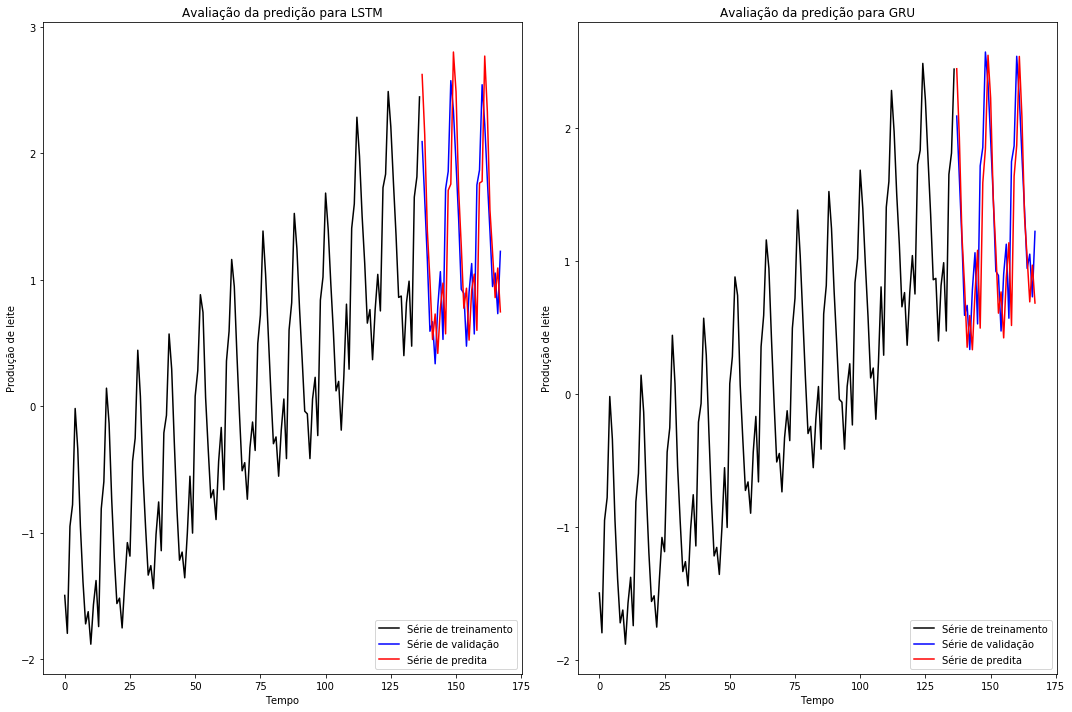

In [44]:
# Plots
fig, ax = plt.subplots(1,2, figsize=(15,10));
# LSTM
ax[0].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[0].plot(xpreds,yv, label='Série de validação', color='blue')
ax[0].plot(xpreds,ypLSTM, label='Série de predita', color='red')  
ax[0].set_title('Avaliação da predição para LSTM')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Produção de leite')
ax[0].legend(loc='lower right')

# GRU
ax[1].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[1].plot(xpreds,yv, label='Série de validação', color='blue')
ax[1].plot(xpreds,ypGRU, label='Série de predita', color='red')  
ax[1].set_title('Avaliação da predição para GRU')
ax[1].set_xlabel('Tempo')
ax[1].set_ylabel('Produção de leite')
ax[1].legend(loc='lower right')
# Default to improve spaces between the plots
plt.tight_layout()

In [45]:
# Avaliar métricas para LSTM
LSTM_metric = lstm_model.evaluate_generator(generator=producao_test_sequence)[1]
print('LSTM alcançou ', LSTM_metric,' de MSE.')

# Avaliar métrica para GRU
GRU_metric = gru_model.evaluate_generator(generator=producao_test_sequence)[1]
print('GRU alcançou ', GRU_metric,' de MSE.')

LSTM alcançou  0.24796736  de MSE.
GRU alcançou  0.21812865  de MSE.


# Parte 6: Preço

## Criação do modelo

In [46]:
# Criando objeto do modelo
ctf_model = Sequential(name='LEITE_MODEL_C_TF')

In [47]:
# Adicionar primeira camada
ctf_model.add(GRU(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
ctf_model.add(GRU(units=100, activation='relu'))
# Adicionar camada de saida
ctf_model.add(Dense(units=1))

# Descrição do modelo
ctf_model.summary()

Model: "LEITE_MODEL_C_TF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 3, 100)            30900     
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


## Aplicação da técnica de Transfer Learning

In [48]:
# Aplicando Transfer Learning
ctf_model.layers[0].set_weights(gru_model.layers[0].get_weights())
ctf_model.layers[1].set_weights(gru_model.layers[1].get_weights())
ctf_model.layers[2].set_weights(gru_model.layers[2].get_weights())

## Compilação e treinamento do modelo

In [63]:
# Compilar o modelo
ctf_model.compile(optimzer='rmsprop', loss='mse', metrics=['mse'])
# Treinando o modelo
CTF_history = ctf_model.fit_generator(preco_train_sequence, epochs=15, verbose=2);

Epoch 1/20
36/36 - 1s - loss: 0.1047 - mse: 0.1050
Epoch 2/20
36/36 - 1s - loss: 0.0997 - mse: 0.1000
Epoch 3/20
36/36 - 1s - loss: 0.0934 - mse: 0.0936
Epoch 4/20
36/36 - 1s - loss: 0.0967 - mse: 0.0970
Epoch 5/20
36/36 - 1s - loss: 0.0971 - mse: 0.0973
Epoch 6/20
36/36 - 1s - loss: 0.0896 - mse: 0.0898
Epoch 7/20
36/36 - 1s - loss: 0.0943 - mse: 0.0946
Epoch 8/20
36/36 - 1s - loss: 0.0871 - mse: 0.0872
Epoch 9/20
36/36 - 1s - loss: 0.0974 - mse: 0.0976
Epoch 10/20
36/36 - 1s - loss: 0.0900 - mse: 0.0903
Epoch 11/20
36/36 - 2s - loss: 0.0954 - mse: 0.0957
Epoch 12/20
36/36 - 1s - loss: 0.1026 - mse: 0.1029
Epoch 13/20
36/36 - 1s - loss: 0.0876 - mse: 0.0874
Epoch 14/20
36/36 - 1s - loss: 0.0938 - mse: 0.0940
Epoch 15/20
36/36 - 1s - loss: 0.0971 - mse: 0.0974
Epoch 16/20
36/36 - 1s - loss: 0.0924 - mse: 0.0927
Epoch 17/20
36/36 - 1s - loss: 0.0903 - mse: 0.0904
Epoch 18/20
36/36 - 1s - loss: 0.0976 - mse: 0.0979
Epoch 19/20
36/36 - 2s - loss: 0.0938 - mse: 0.0940
Epoch 20/20
36/36 - 2

## Avaliação dos resultados

In [64]:
# Prever valores futuros(validação) com GRU para preços da Apple
CTF_pred = ctf_model.predict_generator(generator=preco_test_sequence)

In [65]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(preco_train) + window_size)
xpreds = range(len(preco_train) + window_size, len(preco_train) + len(preco_test))

In [66]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(preco_train.reshape(-1)) + list(preco_test.reshape(-1)[0:window_size])
yv = list(preco_test.reshape(-1))[window_size:]
ypCTF = list(CTF_pred.reshape(-1))

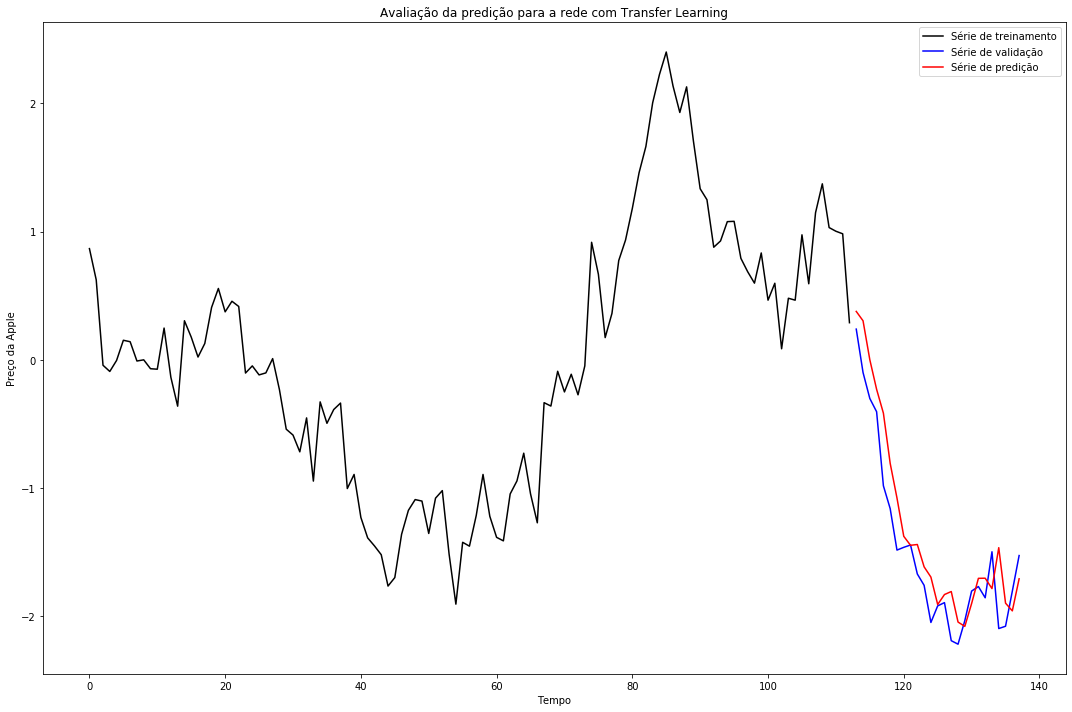

In [68]:
# Plots
fig = plt.figure(figsize=(15,10));
# CTF - Com Transfer Learning
plt.plot(xtrain,yt, label='Série de treinamento', color='black')
plt.plot(xpreds,yv, label='Série de validação', color='blue')
plt.plot(xpreds,ypCTF, label='Série de predição', color='red')  
plt.title('Avaliação da predição para a rede com Transfer Learning')
plt.xlabel('Tempo')
plt.ylabel('Preço da Apple')
plt.legend(loc='upper right')


# Default to improve spaces between the plots
plt.tight_layout()

# Conclusão

# Referências